In [1]:
# Local Stability

In [32]:
import numpy as np
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from pop_dyn_non_dim_one_x import *
from scipy.optimize import fsolve
import matplotlib.pyplot as plt


# Functions

In [2]:
%%writefile local_stability_funs.py
import numpy as np
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from scipy.linalg import eigvals

def fun_Jac(N1,N2,gvec,**params):
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    size = len(gvec)+2


    # stuff used for multiple rows that speeds it up
    # the gradient of f(x) vs N1, N2 for x = 1, 2, ..., x_max. 
    # rows correspond to N1, N2. columns to x
    
    grad_f_1 = fun_grad_func_response(1,xvec,N1,N2,**params)
    grad_f_2 = fun_grad_func_response(2,xvec,N1,N2,**params)
    
    Jac = np.zeros((size,size))
    Jac[0,:] = fun_grad_big_prey(N1, N2, gvec, grad_f_1, **params)
    Jac[1,:] = fun_grad_small_prey(N1, N2, gvec, grad_f_2, **params)
    Jac[2:,:] = fun_Jac_groups_helper(N1, N2, gvec, grad_f_1, grad_f_2, xvec, **params)

    return Jac

def fun_Jac_groups(N1, N2, gvec, params):
    '''
    Finds the Jacobian if N1, N2, p are constant
    '''
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)

    # the gradients of the functional responses relative to big prey and small prey
    grad_f_1 = np.zeros((2,x_max))
    grad_f_2 = np.zeros((2,x_max))


    # the jacobian has two columns that need to be eliminated because they corrrespond to the gradient of dg/dt wrt N1, N2
    Jac_need_to_trim = fun_Jac_groups_helper(N1, N2, gvec, grad_f1, grad_f_2, xvec, **params)

    Jac = Jac[:, 2:]
    return Jac
    
    
def fun_grad_func_response(i,x, N1,N2, A1, A2, **params):
    '''
    The gradient of the (scaled) functional response on prey i wrt N1, N2
    returns an array with 2 rows (N1, N2) and x_max columns
    '''
    alpha1 = fun_alpha1(x,**params)
    alpha2 = fun_alpha2(x,**params)
    H1 = fun_H1(x,**params)
    H2 = fun_H2(x,**params)
    denom = (1 + alpha1 * H1 * N1 + alpha2 * N2 * H2)**2
    if i == 1:
        return np.array([ A1 * alpha1*(1 + alpha2 * H2 * N2), 
                         - A1 * alpha1 * alpha2 * H2 * N1])/denom
    elif i == 2:
        return np.array([ - A2 * alpha1 * alpha2 * H1 * N2,
                         A2 * alpha2 * (1 + alpha1 * H1 * N1)])/denom

def fun_grad_big_prey(N1,N2,gvec, grad_f_1, η1, x_max, **params):
    '''
    return gradient of big prey vs n1, n2, g(1), .. g(x)
    '''
    
    # the sum of  g(x) * [ del g_1/ del N_1, del g_1 / del N_2]
    grad_sum_g_y = np.sum(grad_f_1 * gvec,1)
    
    delU1_N1 = η1 * (1 - 2 * N1) - grad_sum_g_y[0] 
    delU1_N2 = - grad_sum_g_y[1]

    xvec = np.arange(1,x_max+1,1)
    f1_vec = fun_response_non_dim(xvec, N1, N2, 1,**params)
    delU1_g = - f1_vec

    to_return = np.array([delU1_N1, delU1_N2, *delU1_g])

    return to_return

def fun_grad_small_prey(N1,N2,gvec, grad_f_2, η2,  x_max, **params):
    '''
    return gradient of small prey vs n1, n2, g(1), .. g(x)
    '''

    # the sum of g(x) * [ del f_2/ del N_1, del f_2 / del N_2]
    grad_sum_g_y = np.sum(grad_f_2 * gvec,1)

    delU2_N1 = - grad_sum_g_y[0]
    delU2_N2 = η2 * (1 - 2 * N2) - grad_sum_g_y[1]

    xvec = np.arange(1,x_max+1,1)
    f2_vec = fun_response_non_dim(xvec,N1,N2,2,**params)
    delU2_g = - f2_vec

    to_return = np.array([delU2_N1, delU2_N2, *delU2_g])

    return to_return


    
def fun_Jac_groups_helper(N1, N2, gvec, grad_f_1, grad_f_2, xvec, x_max, Tx, d,
                   η1, η2, **params):
    
    Jac = np.zeros((len(gvec),len(gvec)+2))

    # some of the calculations i'll need ready for the actual partial derivatives 
    # of the master equation of dg(x)/dt for x = 1,2, ... , x_max

    
    partial_π = params['β1'] * grad_f_1 + params['β2'] * grad_f_2 # p.d.v. of yield (pi) vs N1, N2 (rows)
                            # for x = 1, 2, ... ,x_max (columns)
    π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params) # yield from
    fitnessvec = π_vec/xvec

    # partial derivative of S(1,x) wrt N1, N2 for x = 1, 2, ...,x_max
    # form [[dS(1,2)/dN1, dS(1,2)/dN2], ..., [dS(1,x_max)/dN1, dS(1,x_max/dN2]]... so rows correspond to x
    partial_S_vec = [fun_partial_S_wrt_prey(N1, N2, x, fitnessvec, π_vec, partial_π, d,**params) \
                                 for x in range(2,x_max+1)]

    S_x_1_vec = [best_response_fun_given_fitness(x,1,fitnessvec,d) for x in range(2,x_max+1)]
    td = 1 - η1 - η2
    def g(x):
        return gvec[x-1]
    def partial_S(x):
        # grad S(1,x) wrt N1, N2
        return partial_S_vec[x-2]
    def S(x,y=1):
        # NEED TO CHECK
        if y == 1:
            return S_x_1_vec[x-2]
        if x == 1:
            return 1 - S_x_1_vec[y-2]
        #return best_response_fun_given_fitness(x,y,fitnessvec,d) # old way that recalculates each time
    def π(x):
        return π_vec[x-1]

    # first row. splitting into portion from group fission/fusion and pop processes
    Q1_Ni_group = (1/Tx) * (2*g(2) * partial_S(2) + \
                       np.sum(np.array([partial_S(x) * ( x * g(x) + g(1) * g(x-1)) \
                               for x in range(2,x_max+1)]),0))
    Q1_Ni_pop = g(x_max) * partial_π[:,-1] - g(1) * partial_π[:,0]
    Q1_Ni = Q1_Ni_group + Q1_Ni_pop
    

    Q1_g1 = (-2*g(1)*S(2) - sum([g(x-1)*S(x,1) \
                                       for x in range(3,x_max+1)]))/Tx - π(1) - td
    Q1_g2 = (4*S(1,2) - g(1)*S(3,1))/Tx + 2*td
    Q1_gx = [(x*S(1,x) - g(1)*S(x+1,1))/Tx for x in range(3,x_max)] #FILL IN
    Q1_gxmax = x_max*S(1,x_max)/Tx + π(x_max)
    Jac[0,:] = np.array([*Q1_Ni, Q1_g1, Q1_g2, *Q1_gx, Q1_gxmax])
    

    # second row
    Q2_Ni = (1/Tx) * ( - partial_S(2) * (2*g(2) + 0.5*(g(1))**2) \
                            + partial_S(3)*(3*g(3) + g(1)*g(2))) \
                        + g(1)*partial_π[:,0] - g(2)*partial_π[:,1]
    Q2_g = np.zeros(len(gvec))
    Q2_g[0] = (1/Tx)* (g(1) * S(2,1) - g(2) * S(3,1)) + π(1)# partial wrt g(1)
    Q2_g[1] = -(1/Tx) * (2* S(1,2) + g(1)*S(3,1)) - π(2) - 2*td
    Q2_g[2] = (3/Tx)*S(1,3) + 3 * td
    
    Jac[1,:] = np.array([*Q2_Ni, *Q2_g])
    

    # 3rd through 2nd to last row (for 2 < x < x_max)
    
    for x in range(3,x_max):
        Qx_Ni = (1/Tx) * (partial_S(x+1) *( (x+1)*g(x+1) + g(1)*g(x) ) \
                          - partial_S(x)*(x*g(x) + g(1)*g(x-1)))\
                    + g(x-1)*partial_π[:,x-2] - g(x) * partial_π[:,x-1]
        
        Qx_g = np.zeros(len(gvec))
        
        Qx_g[0] = (1/Tx)* (g(x-1)*S(x,1) - g(x)*S(x+1,1)) # wrt g(1)
        Qx_g[x-2] = (1/Tx) * g(1)*S(x,1) + π(x-1) # wrt g(x-1)
        Qx_g[x-1] = -(1/Tx) * (x*S(1,x) + g(1)*S(x+1,1)) - π(x) - x*td # wrt g(x)
        Qx_g[x] = (1/Tx)*(x+1)*S(1,x+1) + (x+1)*td # wrt g(x+1)

        Jac[x-1,:] = np.array([*Qx_Ni,*Qx_g])


    # last row, g(x_max)
    Qxmax_Ni = -(1/Tx)*partial_S(x_max) * (x_max*g(x_max) + g(1)*g(x_max-1)) \
                + g(x_max-1)*partial_π[:,x_max-2] 
    Qxmax_g = np.zeros(len(gvec))
    Qxmax_g[0] = (1/Tx)*g(x_max-1)*S(x_max,1)
    Qxmax_g[x_max-2] = (1/Tx)*g(1)*S(x_max,1) + π(x_max-1) # wrt g(x-1)
    Qxmax_g[x_max-1] = -(1/Tx)*x_max*S(1,x_max) - x_max*td
    Jac[-1,:] = np.array([*Qxmax_Ni, *Qxmax_g])
                                           
    
    return Jac
    
def fun_partial_S_wrt_prey(N1, N2, x, π_vec, fitnessvec, partial_π,
                           d, **params):
    '''
    partial derivative of S(1,x) wrt N1, N2 for a specified x
    array with 2 entries corresponding to N1, N2
    '''
    
    S_1_x = best_response_fun_given_fitness(1,x,fitnessvec,d)
    S_x_1 = 1 - S_1_x

    partial_π_of_1 = partial_π[:,0] # [ \partial π(1) / \partial N_1, \partial π(1) / \partial N_2]
    partial_π_of_x = partial_π[:,x-1] # [ \partial π(x) / \partial N_1, \partial π(x) / \partial N_2]
    π_of_1 = π_vec[0] # π(1)
    π_of_x = π_vec[x-1] # π(x)

    partial_S_1_x = d*S_1_x * S_x_1 * ( partial_π_of_1 * 1 / π_vec[0] \
                                   - partial_π_of_x * 1 / π_of_x)
    
    return partial_S_1_x
    

        



def classify_stability(J):
    '''
    Compute the eigenvalues of the Jacobian matrix
    returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)",
    or "Indeterminate stability (needs further analysis)"
    '''
    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues = np.linalg.eigvals(J)
    
    # Check the real parts of the eigenvalues
    real_parts = np.real(eigenvalues)
    
    # Classify the stability based on the real parts of the eigenvalues
    if np.all(real_parts < 0):
        return "Stable (attractive)"
    elif np.any(real_parts > 0):
        return "Unstable"
    elif np.all(real_parts <= 0):
        return "Marginally stable (needs further analysis)"
    else:
        return "Indeterminate stability (needs further analysis)"

def classify_equilibrium(equilibrium, params):
    '''
    equilibrium = [N1, N2, *gvec]
    @ returns: stability (string)

    Note: stability is one of:
    "Stable (attractive)", "Unstable", 
    "Marginally stable (needs further analysis)",
    or "Indeterminate stability (needs further analysis)"
    '''
    [N1,N2,*gvec] = equilibrium
    J = fun_Jac(N1,N2,gvec,**params) 
    if not np.isfinite(J).all():
        print(J)
        print(equilibrium)
        print(params)
    stability = classify_stability(J)
    
    return stability
# def fun_jacobian_one_grp(P, N1, N2, x, η1, η2, A1, β1, β2, **params):
#     H1 = params['H1']
#     H2=params['H2']
#     Y1 = fun_Y1(N1,N2,x,**params)
#     Y2 = fun_Y2(N1,N2,x,**params)
#     α2 = fun_alpha2(x, **params)
#     α1 = fun_alpha1(x, **params)
#     td = 1 - η1 - η2
#     A2 = 1 - A1
    
#     J = np.zeros((3, 3))

#     J[0, 0] = -td + (1/x) * (β1 * Y1 + β2 * Y2)
#     J[0, 1] = P / x * β1 * (α1 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
#     J[0, 2] = P / x * β2 * (α2 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
    
    
#     J[1, 0] = -A1 * Y1 / x
#     J[1, 1] = η1 * (1 - 2 * N1) - P / x * A1 * (α1 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
#     J[1, 2] = -P / x * A1 * (α1 * α2 * H2 * N2 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
    
    
#     J[2, 0] = -A2 * Y2 / x
#     J[2, 1] = -P / x * A2 * (α2 * α1 * H1 * N1 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
#     J[2, 2] = η2 * (1 - 2 * N2) - P / x * A2 * (α2 / (1 + H1 * α1 * N1 + H2 * α2 * N2)**2)
    
#     return J

''' 
this needs to be fixed: 
'''
def fun_Jac_groups_nopop(N1, N2, gvec, x_max, Tx, d, **params):
    '''
    Finds the Jacobian for group dynamics with no populatin dynamics
    '''
    
    Jac = np.zeros((len(gvec),len(gvec)+2))
    
    def g(x):
        return gvec[x-1]
    def S(x,y=1):
        return best_response_fun_given_fitness(x,y,fitnessvec,d)

        
    # first row    
    Q1_g1 = (-2*g(1)*S(2,1) - sum([g(x)*S(x+1,1) \
                                       for x in range(2,x_max)]))/Tx 
    Q1_g2 = (4*(1-S(2)) - g(1)*S(3))/Tx 
    Q1_gx = [(x*(1-S(x)) - g(1)*S(x+1))/Tx for x in range(3,x_max)] #FILL IN
    Q1_gxmax = x_max*(1 - S(x_max))/Tx 
    Jac[0,:] = np.array([Q1_g1, Q1_g2, *Q1_gx, Q1_gxmax])

    # second row
    Q2_g = np.zeros(len(gvec))
    Q2_g[0] = (1/Tx)* (g(1) * S(2) - g(2) * S(3)) # partial wrt g(1)
    Q2_g[1] = -(1/Tx) * (2* (1 - S(2)) + g(1)*S(3)) 
    Q2_g[2] = (3/Tx)*(1 - S(3)) 
    
    Jac[1,:] = Q2_g

    # 3rd through 2nd to last row (for 2 < x < x_max)
    
    for x in range(3,x_max):
        
        Qx_g = np.zeros(len(gvec))
        
        Qx_g[0] = (1/Tx)* (g(x-1)*S(x) - g(x)*S(x+1)) # wrt g(1)
        Qx_g[x-2] = (1/Tx) * g(1)*S(x) # wrt g(x-1)
        Qx_g[x-1] = -(1/Tx) * (x*(1 - S(x)) + g(1)*S(x+1)) # wrt g(x)
        Qx_g[x] = (1/Tx)*(x+1)*(1-S(x+1)) # wrt g(x+1)

        Jac[x-1,:] = Qx_g



    Qxmax_g = np.zeros(len(gvec))
    Qxmax_g[0] = (1/Tx)*g(x_max-1)*S(x_max,1)
    Qxmax_g[x_max-2] = (1/Tx)*g(1)*S(x_max,1)  # wrt g(x-1)
    Qxmax_g[x_max-1] = -(1/Tx)*x_max*S(1,x_max) 
    Jac[-1,:] = Qxmax_g
                                           
    
    return Jac

Overwriting local_stability_funs.py


# Check

In [1]:
from group_w_pop_funs import bounded_ivp
from bif_diagram_funs import update_params, get_perturbations
from equilibria_funs import iterate_to_eq

In [16]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)
params = update_params("scale", 12, params_base)

initialstate = [0.7, 0.7, 1,1,1,1e-4,1e-4]
equilibrium, success, timederivatives = iterate_to_eq(
    np.array(initialstate), t_f=1100, params=params
)
equilibrium_nomean = np.array(equilibrium)[:-1]
perturbations = get_perturbations(equilibrium_nomean, 5, .01)

In [4]:
equilibrium

NameError: name 'equilibrium' is not defined

In [19]:
for item in perturbations:
    curr, success, timederivatives = iterate_to_eq(
        np.array(initialstate), t_f=1100, params=params
    )
    print(np.abs(curr - equilibrium))
    print(success)
    

[0. 0. 0. 0. 0. 0. 0. 0.]
True
[0. 0. 0. 0. 0. 0. 0. 0.]
True
[0. 0. 0. 0. 0. 0. 0. 0.]
True
[0. 0. 0. 0. 0. 0. 0. 0.]
True
[0. 0. 0. 0. 0. 0. 0. 0.]
True


In [21]:
[N1,N2,*gvec] = curr[:-1]
jac = fun_Jac(N1,N2,gvec,**params)
classify_stability(jac)

'Stable (attractive)'

In [ ]:
# since iterated to this, it should be stable

In [4]:
H=1
x_max = 4
params_base = dict(η1 = 0.2, η2 = 0.4, A = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)


# One group Size

In [11]:
initial_guess = [1.0, 0.5, 0.5]
x=9
params=params_base.copy()
equilibrium = fsolve(full_system_one_grp, initial_guess, args=(x,params))
P_eq, N1_eq, N2_eq = equilibrium
print(f'Equilibrium: P={P_eq:.3f}, N1={N1_eq:.3f}, N2={N2_eq:.3f}')
J_eq = fun_jacobian_one_grp(P_eq, N1_eq, N2_eq, x, **params)
print('Jacobian at equilibrium:')
print(J_eq)

# Calculate the eigenvalues of the Jacobian
eigenvalues = eigvals(J_eq)
print('Eigenvalues of the Jacobian:')
print(eigenvalues)

# Evaluate local stability
if np.all(np.real(eigenvalues) < 0):
    print('The equilibrium is locally stable.')
else:
    print('The equilibrium is not locally stable.')

classify_stability(J_eq)

Equilibrium: P=1.190, N1=0.818, N2=-0.000
Jacobian at equilibrium:
[[-3.00523560e-01  3.19999998e-01  3.79999999e-02]
 [ 1.73851696e-21 -1.47272728e-01  1.89951575e-19]
 [-4.97382199e-02 -1.55454545e-02  3.81000000e-01]]
Eigenvalues of the Jacobian:
[-0.29773891+0.j  0.37821535+0.j -0.14727273+0.j]
The equilibrium is not locally stable.


'Unstable'

# Multiple Group Sizes

In [30]:
x_max = 4
N1 = 1; N2 = 1; xvec = np.arange(1,x_max+1,1)
params = params_base.copy()
gvec = np.array([1, 1,0,0])
J = fun_Jac(N1,N2,gvec,**params)
evals = np.linalg.eigvals(fun_Jac(N1,N2,gvec,**params))
classify_stability(J)

'Stable (attractive)'

In [20]:
initialstate = [1,1, *gvec];
full_model(1,initialstate,True,params.copy())

[np.float64(-0.1145408163265306),
 np.float64(-0.4313775510204081),
 np.float64(-188.93907936065182),
 np.float64(-53.54715764750079),
 np.float64(98.72703291242868),
 np.float64(0.0)]

In [37]:
gvec_out.shape

(4, 179)

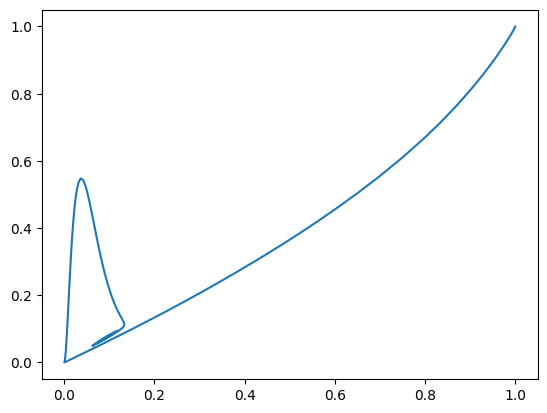

In [52]:
from scipy.integrate import odeint, solve_ivp
H=0
x_max = 4
params_base = dict(η1 = 0.3, η2 = 0.6, A = 1, β1 = 3, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

initialstate = np.array([1,1, *gvec]);
t_f=3000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params_base.copy()))
T = out2.t
N1 = out2.y[0]
N2 = out2.y[1]
gvec_out = out2.y[2:]
plt.plot(N1,N2)

In [55]:
N1_f = N1[-1]
N2_f = N2[-1]
g_f = gvec_out[:,-1]
J = fun_Jac(N1_f,N2_f,g_f,**params_base.copy())
evals = np.linalg.eigvals(J)
classify_stability(J)

'Stable (attractive)'

In [42]:
evals

array([-1.11617136e+02+0.j        , -3.37343234e+01+0.j        ,
       -1.64998820e+01+0.j        , -2.83775411e-01+0.j        ,
       -5.04755175e-02+0.09983833j, -5.04755175e-02-0.09983833j])

In [52]:
np.abs(evals)

array([2.46477677e+02, 2.46477677e+02, 1.03384471e+02, 1.49719703e-01,
       1.49719703e-01, 6.60341699e-01])

In [119]:
π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params)
fitnessvec = π_vec/xvec
d=params['d']
best_response_fun_given_fitness(3,1,fitnessvec,d)

np.float64(0.5)

In [118]:
W3 = fitnessvec[2]
W1 = fitnessvec[0]

W3**d/(W1**d + W3**d)

np.float64(0.9771682883079603)

In [82]:
def best_response_fun_given_fitness(x,y,fitnessvec, d):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    fitnessvec - vector of fitnesses fro x = 1, 2, ..., xmax
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model 
    @returns:
    float between 0 and 1
    '''
    W_of_x = fitnessvec[x-1]
    W_of_y = fitnessvec[y-1]
    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    if W_max > 0:
        numerator = (W_of_x/W_max)**d
    else:
        return 0
    denominator = 1 + (W_min/W_max)**d # this adjustment helps avoid dividing by zero from numpy rounding
    return numerator/denominator

array([[  -2.77509103,    1.42509103, -201.75      ,  100.8       ,
          50.        ,  208.92790055],
       [   1.58754552,   -0.23754552,  101.35      , -205.75      ,
         151.2       ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         108.55      ,  -10.52790055]])

In [120]:
x=3; y = 1
W_of_x = fitnessvec[x-1]
W_of_y = fitnessvec[y-1]
W_min = min(W_of_x, W_of_y)
W_max = max(W_of_x, W_of_y)

In [131]:
if W_max > 0:
    numerator = (W_of_x/W_max)**d
    print(numerator)


1.0


In [133]:
W3

np.float64(0.9827586206896551)

In [27]:
π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params)
fitnessvec = π_vec/xvec
S_1_x = best_response_fun_given_fitness(1,x,fitnessvec,d)
S_x_1 = 1 - S_1_x
partial_π[0]

array([0.4, 4. , 7.6])

In [29]:
    
def fun_partial_S_wrt_prey(N1, N2, x, partial_π,
                           d, **params):
    '''

    array with 2 entries corresponding to N1, N2
    '''

    xvec = np.arange(1, params['x_max']+1,1)
    π_vec = yield_from_prey_non_dim(xvec, N1, N2, **params)
    fitnessvec = π_vec/xvec
    
    
    S_1_x = best_response_fun_given_fitness(1,x,fitnessvec,d)
    S_x_1 = 1 - S_1_x

    partial_S_1_x = d*S_1_x * S_x_1 * ( partial_π[:,0] * 1 / π_vec[0] \
                                   - partial_π[:,x-1] * 1 / π_vec[x-1])
    
    return partial_S_1_x
    





def fun_grad_g_1(N1,N2,f,partial_π, partial_S_prey, **params):
    '''
    The partial of Q1 wrt N1, N2, g(1), ..., g(x_m)
    '''
    partialQ1_partial_prey = fun_partialQ1_partialNi(N1,N2,f,partial_π, 
                                                     partial_S_prey, **params)
    partialQ1_partial_g = fun_partialQ1_partial_group(N1,N2,f, partial_π, 
                                                      partial_S_prey,**params)
    to_return = [*partialQ1_partial_prey, *partialQ1_partial_g]
    return np.array(to_return)
    
def fun_partialQ1_partialNi(N1,N2,gvec, partial_π,  
                            Tx, x_max, **params):
    '''
    the partial derivative of Q_1 with respect to N1, N2
    
    '''
    
    def g(x):
        return gvec[x-1]
    def partial_S(x):
        return 0 # FILL IN
        
    group_part = 2*g(1) * partial_S(2) + \
                        np.sum([partial_S(x) * (x*g(x) + g(1)*g(x-1)) \
                                for x in range(2,x_max+1)])#FILL IN
    pop_part = 0 #FILL IN
    to_return = group_part/Tx + pop_part
    return np.array([0,0]) + gvec[0]
                    
def fun_partialQ1_partial_group(N1,N2,gvec, partial_π,  **params):
    '''
    FILL IN
    '''
    return np.zeros(len(gvec)) + gvec[0]

def fun_grad_g_2(N1,N2,gvec,xvec,**params):
    to_return = np.zeros(len(gvec) + 2)
    return to_return + gvec[1]

def fun_grad_g_mid_x(N1,N2,gvec,xvec,**params):
    to_return = np.zeros(len(gvec) + 2)
    return to_return + gvec[2]
    
def fun_grad_g_max_x(N1,N2,gvec,xvec,**params):
    to_return = np.zeros(len(gvec) + 2)
    return to_return + gvec[2]

In [75]:
H=0
x_max = 2
params_base = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)


In [76]:
params = params_base.copy()
xvec = np.arange(1,x_max+1,1); N1 =1; N2=1;
f = np.array([1,0])
fun_Jac(N1,N2,gvec,**params)

array([[-0.225, -0.   , -0.025, -0.25 ],
       [-0.   , -0.875, -0.475, -0.475],
       [ 1.   ,  1.   ,  1.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

In [67]:
fun_Jac(0.5,0.4,[0.5,0.2,1],3,**dict(η1 = .1, η2 = .3, A1 = 0.5))

TypeError: fun_grad_func_response() missing 2 required positional arguments: 'H1' and 'H2'